# Execute requests

- TODO: Format different function calls in ./tools/templates
- TODO: Preprocess data from non-movie sets
- TODO: Make gpt call separate module, to swap out with local LLM
- TODO: Add better eval metrics

In [1]:
# ! pip install openai langchain -q

In [2]:
from sklearn.metrics import f1_score, recall_score, roc_auc_score
import os
import json
import csv
import sys
sys.path.append('tools')

from utils import *
import openai_chains
import local_llm_chains

from dotenv import load_dotenv

# Load api key
load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY")

In [3]:
# Retrieve samples at random from formatted dataset
sample_size = 500
data_path = './../data/video/preprocessed_movies.json'

rows = extract_rows(sample_size, data_path)

## Define model and function calling

### OpenAI inference and evaluation

In [4]:
from langchain.prompts import ChatPromptTemplate
from langchain.chat_models import ChatOpenAI

# model = ChatOpenAI(model_name="gpt-3.5-turbo", openai_api_key=openai_api_key, temperature=0)

# chain = openai_chains.get_chain('base_explain', model)

# pred = []
# truth = []
# title = []
# explanations = []

# evaluated = 0

# # Run inference on the chain
# for i, user in enumerate(rows[5:]):    
#     try:
#         prefs = format_preferences(user)
#     except Exception as e:
#         print(f"Error: {e} for user {user}")
#     pass
        
#     # This is where the model is actually called
#     response = chain.invoke(prefs)
#     prediction = json.loads(response.additional_kwargs['function_call']['arguments'])
    
#     print(prediction)
#     selected_attributes = ['likes', 'dislikes', 'target', 'truth']

#     print(json.dumps({attr: prefs[attr] for attr in selected_attributes}, indent=4))
#     evaluated += 1
#     if evaluated == 2:
#         break


### Local Models Inference and Evaluation

In [5]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
from tqdm import tqdm

In [6]:
# Load model
tokenizer = AutoTokenizer.from_pretrained("mistralai/Mixtral-8x7B-Instruct-v0.1",
                                          padding_side='left')
model = AutoModelForCausalLM.from_pretrained("mistralai/Mixtral-8x7B-Instruct-v0.1",
                                             load_in_4bit=True,
                                             torch_dtype=torch.float16,
                                             device_map="auto",
                                             cache_dir='/mnt/sdb1/LLM_RecSys/models',
                                             )

Loading checkpoint shards:   0%|          | 0/19 [00:00<?, ?it/s]

In [10]:
# Retrieve chain and run inference

chain = local_llm_chains.get_chain('base_explain_probs', model, tokenizer)

evaluated = 0
# Run inference on the chain
for i, user in enumerate(rows[10:]):    
    try:
        prefs = format_preferences(user)
    except Exception as e:
        print(f"Error: {e} for user {user}")
    pass
        
    # This is where the model is actually called
    response = chain.invoke(prefs)
    
    # Prints User
    selected_attributes = ['target', 'truth']
    # selected_attributes = ['likes', 'dislikes', 'target', 'truth']
    print("\nUSER:", json.dumps({attr: prefs[attr] for attr in selected_attributes}, indent=4))
    
    print("\nRESPONSE:", json.dumps(response, indent=4))
    
    evaluated += 1
    if evaluated == 10:
        break

50%. The user has shown interest in movies that involve adventure and action, such as 'Secondhand Lions' and 'Fortress'. Moodtapes: Pacific Surf, being a surfing movie, also has an adventurous element. However, the user has not shown any preference towards water-based activities or documentaries, which might make them less likely to enjoy this movie.

USER: {
    "target": "Moodtapes: Pacific Surf",
    "truth": true
}

RESPONSE: {
    "recommend": 0.5,
    "explanation": "The user has shown interest in movies that involve adventure and action, such as 'Secondhand Lions' and 'Fortress'. Moodtapes: Pacific Surf, being a surfing movie, also has an adventurous element. However, the user has not shown any preference towards water-based activities or documentaries, which might make them less likely to enjoy this movie."
}
60%. The user has shown interest in animated movies, as indicated by their positive response to 'The Incredibles (Mandarin Chinese Edition)' and 'Robots VHS'. 'Escape From

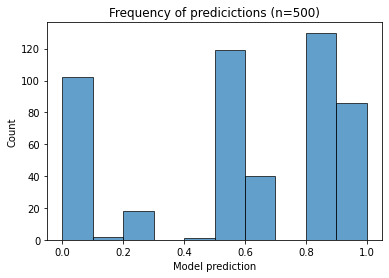

In [4]:
import pandas as pd
df = pd.read_csv('../results/Mixtral-8x7B-Instruct-v0.1/output/base_probs.csv')
ans = df['pred']

%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(ans, bins=10, edgecolor='black', alpha=0.7)
plt.title('Frequency of predicictions (n=500)')
plt.xlabel('Model prediction')
plt.ylabel('Count')
plt.savefig('../figures/probability_histogram.png')
plt.show()